# Import Modules

In [26]:
# Restart runtime after running this
!pip install arch
!pip install pmdarima
!pip install yfinance

In [142]:
import pandas as pd
import numpy as np
import pylab
import scipy.stats as stats
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from arch import arch_model
from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance
sns.set()

# Load & Analyse Data

In [28]:
!wget https://raw.githubusercontent.com/AlvinChiew/MachineLearning/main/raw_data/IndexE8.csv

--2021-04-05 16:19:02--  https://raw.githubusercontent.com/AlvinChiew/MachineLearning/main/raw_data/IndexE8.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297722 (291K) [text/plain]
Saving to: ‘IndexE8.csv’

IndexE8.csv         100%[===================>] 290.74K  --.-KB/s    in 0.04s   

2021-04-05 16:19:02 (7.23 MB/s) - ‘IndexE8.csv’ saved [297722/297722]



In [29]:
# Stailiy or stock exchange for S&P500 US, DAX30 Germany, FTSE100 UK & NIKKEI225 Japan up to 2018
data_idx18 = pd.read_csv("IndexE8.csv")
data_idx18.head(3)

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25


In [30]:
data_idx18.isna().sum()
# no null value to impute 

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

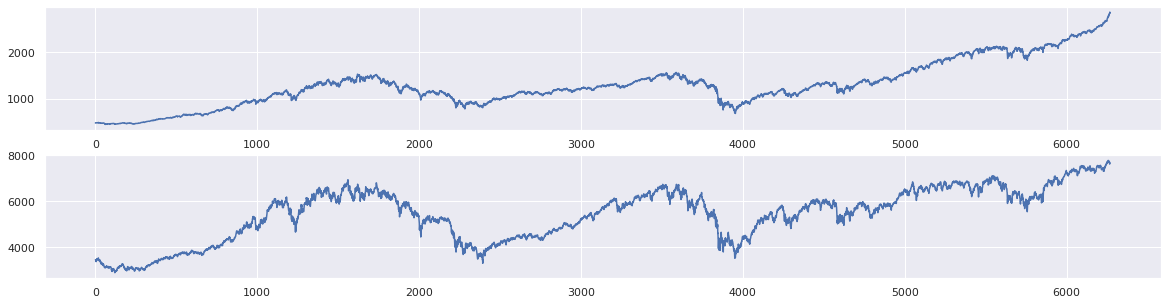

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(20,5))
axes[0].plot(data_idx18["spx"])
axes[1].plot(data_idx18["ftse"])
# Similar pattern trended periodically

QQ plot - shows if data is normally distributed

((array([-3.69357572, -3.46171913, -3.33410335, ...,  3.33410335,
          3.46171913,  3.69357572]),
  array([ 438.92    ,  441.49    ,  441.96    , ..., 2839.253031,
         2853.528411, 2872.867839])),
 (476.46056102841175, 1288.1275420815123, 0.9767273150948813))

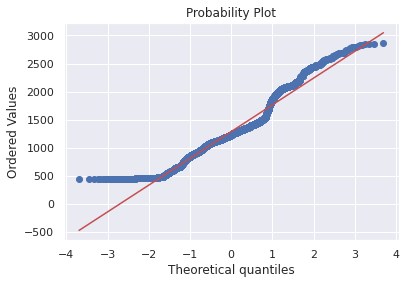

In [32]:
stats.probplot(data_idx18["spx"], plot=pylab)
# not normally distributed, 500 marks holds more value in lower quantiles.

# Data PreProcessing


In [33]:
data_idx18["date"] = pd.to_datetime(data_idx18["date"], dayfirst=True)
data_idx18.set_index("date", inplace=True)
data_idx18.head(3)

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25


In [34]:
df_spx = data_idx18.copy()
df_spx.drop(df_spx.columns.difference(['spx']), 1, inplace=True)
df_spx.head(3)

,spx
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13


Change date frequency to business day

In [35]:
df_spx = df_spx.asfreq('b')     # frequency accurate to business day; 'd' - day
df_spx.head(3)

,spx
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13


Check & fill up null cell

In [36]:
df_spx.isna().sum()

spx    8
dtype: int64

In [37]:
df_spx.fillna(method="ffill", inplace=True)       # method: fffil, bfill / vallue:data.mean()
df_spx.isna().sum()

spx    0
dtype: int64

Train Test Split

In [38]:
SPLIT = 0.8
idx_split = int(df_spx.shape[0] * SPLIT)

df_spx_train = df_spx.iloc[:idx_split]
df_spx_test = df_spx.iloc[idx_split:]

In [39]:
 df_spx_train.tail(3)

,spx
date,
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [40]:
df_spx_test.head(3)

,spx
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827


Check for stationarity with Dickey-Fuller Test

In [41]:
df_spx_train.shape

(5021, 1)

In [42]:
sts.adfuller(df_spx_train['spx'])
# t-statistics = -1.737
# critical values @ 5% = -2.862

# t-statistics > critical value, so no significant stationarity
# p-value = 0.4, so 40% chance of not reject null hypothesis, so this test case is not enough to prove

# lag = 18, so auto-correlation is (x(t), x(t-18))
# sample size = 5002 period samples

# maximized information criterion if autolag is not None = 39905, the lower the easier to be used for future prediction

(-1.7369847452352454,
 0.4121645696770613,
 18,
 5002,
 {'1%': -3.431658008603046,
  '10%': -2.567077669247375,
  '5%': -2.862117998412982},
 39904.880607487445)

Check for Seasonality with decomposition

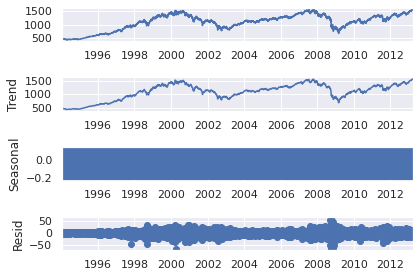

In [43]:
s_dec = seasonal_decompose(df_spx_train, model='additive')
s_dec.plot();

# observed - best predictor for today's value is one from immediate previous value
# trend - explains most of the variability
# seasonal - oscilated between -0.2 and 0.1 among periods, so no concrete cyclical pattern
# residual - error from the model's estimation compared to true value, varies greatly on 2000 and 2008, possibly caused by dot com and housing prices bubble

# Summary - no seasonality in the data

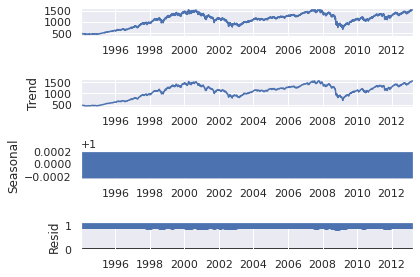

In [44]:
s_dec = seasonal_decompose(df_spx_train, model='multiplicative')
s_dec.plot();
# very similar result

Auto Correlation Function (ACF)<br>
A direct correlation between lagged and current time & indirect correlation betwen lagged time, each time between lagged and current time

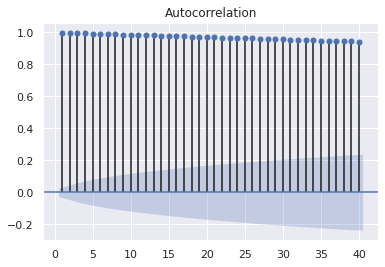

In [45]:
sgt.plot_acf(df_spx_train['spx'], lags=40, zero=False);      # zero=False to exclude current period into the graph becasue correlation betwween current period and current period = 1
# x-axis = lags - 1 to 40
# y-axis = correlation - betwen -1 to 1
# shaded area on x-axis = significance from zero

# Summary - 
# autocorrelation exists, 
# greater lag = more unlikely that autocorrelation persists based on significance
# higher lines than itself in blue region suggests the coefficient is significance and indicates time dependence data
# Autocorrelation barely drops with 40 lags comparing to lag, so it is still a decent estimates for this time series

Partial Auto-correlation Function (PACF) <br>
 A direct correlation between lagged and current time

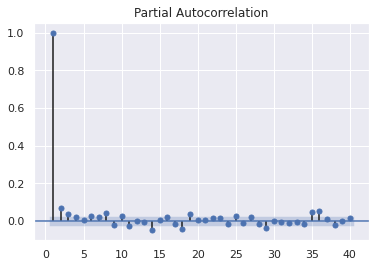

In [46]:
sgt.plot_pacf(df_spx_train['spx'], lags=40, zero=False, method='ols');
# first lag in ACF and PACF are the same as expected
# most value after the third lag are in blue area, so they are significantly different from 0, so not important in estimation

# Modeling

## FTSE - Prices

In [47]:
def data_prep(df_raw, col_name, split_ratio):
    df = df_raw.copy()
    # df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    # df.set_index("date", inplace=True)
    df.drop(df.columns.difference([col_name]), 1, inplace=True)
    df.rename(columns={col_name : "market_value"}, inplace=True)
    df = df.asfreq('b')
    df = df.fillna(method='ffill')
    
    idx_split = int(df.shape[0] * SPLIT)
    df_train, df_test = df.iloc[:idx_split], df.iloc[idx_split:]

    return (df_train, df_test)

### 1a. AR

In [48]:
df_ftse_train, df_ftse_test = data_prep(data_idx18, 'ftse', 0.8 )

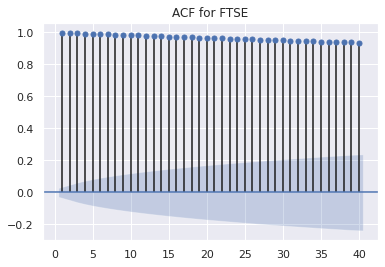

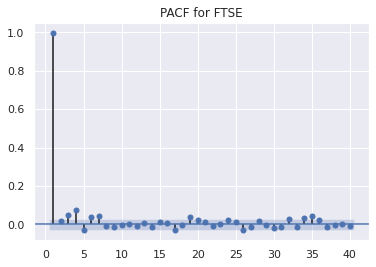

In [49]:
sgt.plot_acf(df_ftse_train['market_value'], zero=False, lags=40, title='ACF for FTSE'); 
sgt.plot_pacf(df_ftse_train['market_value'], zero=False, lags=40, alpha=0.05, method='ols', title='PACF for FTSE'); 
# similar to S&P

In [50]:
# simple AR(1) model
model_ar_1 = ARMA(df_ftse_train['market_value'], order=(1,0))     # order = (lag, residuals) 
result_ar_1 = model_ar_1.fit()

In [51]:
print(result_ar_1.summary())
# x(t) = C + W * x(t-1) + E(t)

# const : C
# ar.L1 : W 

# W is almost 1, which explains the observeration from ACF & PACF where immediate past is critically important

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.599
Method:                       css-mle   S.D. of innovations             59.258
Date:                Mon, 05 Apr 2021   AIC                          55251.198
Time:                        16:19:09   BIC                          55270.762
Sample:                    01-07-1994   HQIC                         55258.054
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5067.4707    486.503     10.416      0.000    4113.942    6021.000
ar.L1.market_value     0.9985      0.001   1298.545      0.000       0.997       1.000
                    

In [52]:
# AR(2) model
model_ar_2 = ARMA(df_ftse_train['market_value'], order=(2,0))     # order = (lag, residuals) 
result_ar_2 = model_ar_2.fit()
print(result_ar_2.summary())

# P(ar.L2) = 0.226, which > 0.05, which means the coefficient isn't significantly different from 0
# so, prices from 2 days ago does not significantly affect the price today

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -27621.866
Method:                       css-mle   S.D. of innovations             59.249
Date:                Mon, 05 Apr 2021   AIC                          55251.732
Time:                        16:19:10   BIC                          55277.817
Sample:                    01-07-1994   HQIC                         55260.872
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5028.8087    495.980     10.139      0.000    4056.706    6000.911
ar.L1.market_value     0.9814      0.014     69.595      0.000       0.954       1.009
ar.L2.market_value  

In [53]:
model_ar_3 = ARMA(df_ftse_train['market_value'], order=(3,0))     # order = (lag, residuals) 
result_ar_3 = model_ar_3.fit()
print(result_ar_3.summary())

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(3, 0)   Log Likelihood              -27615.871
Method:                       css-mle   S.D. of innovations             59.178
Date:                Mon, 05 Apr 2021   AIC                          55241.742
Time:                        16:19:11   BIC                          55274.349
Sample:                    01-07-1994   HQIC                         55253.168
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    520.345      9.781      0.000    4069.784    6109.499
ar.L1.market_value     0.9806      0.014     69.619      0.000       0.953       1.008
ar.L2.market_value  

### Log Likelihood Ratio Test
measures tbe goodness of fit

In [54]:
def llr_test(result_1, result_2, deg_of_freedom =1):      # dof = diff in # lag between model 1&2
    l1 = result_1.llf
    l2 = result_2.llf
    LR = (2*(l2-l1))
    p = stats.chi2.sf(LR , deg_of_freedom).round(3)

    return p

In [55]:
llr_test(result_ar_1, result_ar_2)

0.226

In [56]:
llr_test(result_ar_2, result_ar_3)
# p-value < 0.05, so it suggests to use the more complex model, i.e. AR(3)
# remark: check for coeff in AR(3) too to see if coeff is significantly close to 0 before deciding 

0.001

In [57]:
type(df_ftse_train['market_value'])

pandas.core.series.Series

In [58]:
def llr_tests(series, max_lag=10):
    model_results = {}
    llr_results = {}

    for i in range(1, max_lag):
        model_ar = ARMA(series, order=(i,0)) 
        model_results[i] = model_ar.fit()
        if i-1 in model_results.keys():
            llr_results[i] = llr_test(model_results[i-1], model_results[i])

    print(llr_results)
    return model_results

In [59]:
model_results = llr_tests(df_ftse_train['market_value'])
# AR(8) onwards are insignificant (LLR > 0.05)
# AR(7) will be optimimal to use

# AR(1) is better than AR(2)
# AR(7) is better than AR(1), but with some non-significant/close-to-zero coefficient

{2: 0.226, 3: 0.001, 4: 0.0, 5: 0.035, 6: 0.005, 7: 0.002, 8: 0.571, 9: 0.288}


In [60]:
llr_test(model_results[1], model_results[7], 6) # LLR test between AR(1) and AR(7)
# LLR p-value < 0.05, ok to use.

0.0

### Dickey-Fuller-Test

Check if data is stationarity

In [61]:
sts.adfuller(df_ftse_train['market_value'])
# p-value = 0.33, >0.05, so it's not a stationary time-series
# AR works well on stationary time-series but not non-stationary, so we shouldn't use AR model

(-1.9041551418836857,
 0.3301089327702835,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 54854.15304507557)

## FTSE - Returns

Transform Dataset to "Stationary"

In [62]:
# replaces prices with returns in market_value indexes
df_ftse_train['return'] = df_ftse_train['market_value'].pct_change(1).mul(100)   # return = (P(t) - P(t-1)) / p(t-1) * 100%
df_ftse_train = df_ftse_train.iloc[1:]        # remove first row record as the % change will be null due to the absence of previous value

In [63]:
sts.adfuller(df_ftse_train['return'])
# p-value ~~ 0, <0.05,
# t-statistics = -12.77
# critical values @ 1% = -3.43
# t-statistics < critical value,  so it's a stationary time-series

(-12.770265719497248,
 7.798058336037938e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '10%': -2.5670785949998973,
  '5%': -2.8621197374408225},
 15696.7672456975)

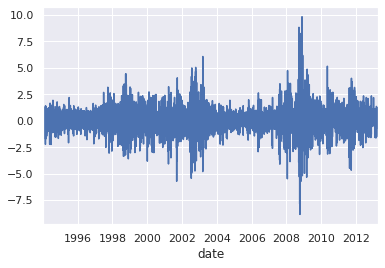

In [64]:
df_ftse_train['return'].plot();

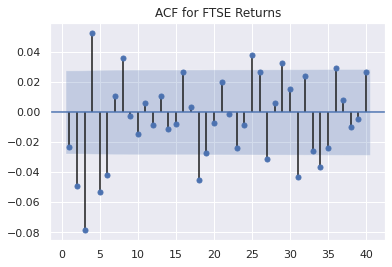

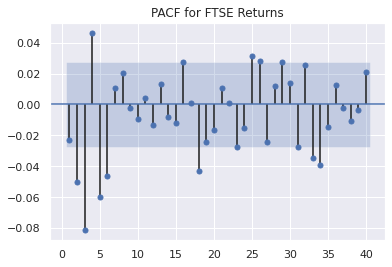

In [65]:
sgt.plot_acf(df_ftse_train['return'], zero=False, lags=40, title='ACF for FTSE Returns'); 
sgt.plot_pacf(df_ftse_train['return'], zero=False, lags=40, alpha=0.05, method='ols', title='PACF for FTSE Returns'); 

# ACF 
# First 6 lags are significant (outside shaded area)
# Negative coeff - consecutive value moves in different directions

# PACF
# Similar to ACF - price increment/decrement today often move in opposite direction of yesterday
# higher lags, less significant - majority effects from long ago have been accounted already in the nearer past due to reccursive nature by cyclical change 

### 1b. AR

In [66]:
model_ar_1 = ARMA(df_ftse_train['return'], order=(1,0))     # order = (lag, residuals) 
result_ar_1 = model_ar_1.fit()
print(result_ar_1.summary())

# C & L1 p-val > 0.05, so neither is significantly differenrt from 0 
# no predictive power

                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Mon, 05 Apr 2021   AIC                          15865.497
Time:                        16:19:28   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.return    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots   

In [67]:
model_ar_2 = ARMA(df_ftse_train['return'], order=(2,0))     # order = (lag, residuals) 
result_ar_2 = model_ar_2.fit()
print(result_ar_2.summary())
print(llr_test(result_ar_1, result_ar_2))

# L3 is significant, L2 is more significant in AR(2) than AR(1)
# LLR p-val < 0.05, *IC are better too in AR(2), so AR(2) is better than AR(1)

                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood               -7923.456
Method:                       css-mle   S.D. of innovations              1.173
Date:                Mon, 05 Apr 2021   AIC                          15854.911
Time:                        16:19:29   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0188      0.015      1.220      0.222      -0.011       0.049
ar.L1.return    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.return    -0.0500      0.014     -3.55

In [68]:
llr_tests(df_ftse_train['return'])
# AR(6) is the best, AR(7) p-val > 0.05

{2: 0.0, 3: 0.0, 4: 0.001, 5: 0.0, 6: 0.001, 7: 0.44, 8: 0.148, 9: 0.885}


{1: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f0404949b10>,
 2: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f04049499d0>,
 3: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f0404d62ed0>,
 4: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f0404992c10>,
 5: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f0404b912d0>,
 6: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f04049b1150>,
 7: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f04049d5ad0>,
 8: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f0404f06410>,
 9: <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f04049523d0>}

### Normalization

transform all data into % delta of the first data point/period

In [69]:
first_val = df_ftse_train['return'].iloc[0]
df_ftse_train['norm_return'] = df_ftse_train['return'].div(first_val).mul(100)
sts.adfuller(df_ftse_train['norm_return'])
# normalization does NOT affect stationarity

(-12.77026571949728,
 7.798058336036651e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '10%': -2.5670785949998973,
  '5%': -2.8621197374408225},
 80114.49116124898)

### Residual Extraction

Obtain resdual, E(t) from all periods. Residual should behave like a random walk series & stationary

In [70]:
model_ar_6 = ARMA(df_ftse_train['return'], order=(6,0))     # order = (lag, residuals) 
result_ar_6 = model_ar_6.fit()

residual mean : -0.000054
residual variance : 1.36


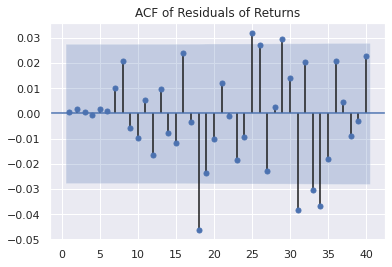

In [71]:
df_ftse_train['residual_return'] = result_ar_6.resid
print('residual mean : {:2f}'.format(df_ftse_train['residual_return'].mean()))
print('residual variance : {:.2f}'.format(df_ftse_train['residual_return'].var()))
sts.adfuller(df_ftse_train['residual_return'])
sgt.plot_acf(df_ftse_train['residual_return'], zero=False, lags=40, title='ACF of Residuals of Returns');

# residual close to 0 : low error from preditcion. good choice of model
# low variance relative to mean : error does not fluctuate aggressively in general 
# DF test : residual is stationary (residual is white noise)
# ACF of residual shows no correlation from one period to another, expected as correlations should be already captured by 'return' model

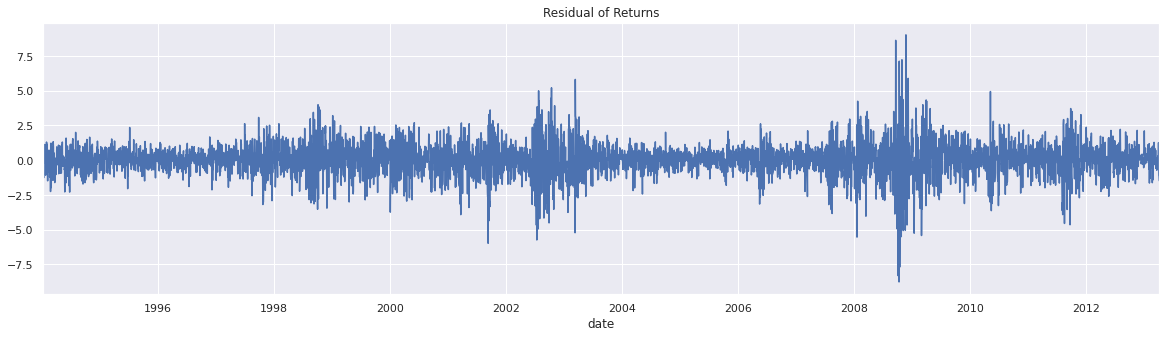

In [72]:
df_ftse_train['residual_return'].plot(figsize=(20,5), title='Residual of Returns');

###  2. MA



In [73]:
def llr_tests_ma(series, max_lag=10):
    model_results = {}
    llr_results = {}

    for i in range(1, max_lag):
        model_ar = ARMA(series, order=(0,i)) 
        model_results[i] = model_ar.fit()
        if i-1 in model_results.keys():
            llr_results[i] = llr_test(model_results[i-1], model_results[i])

    print(llr_results)
    return model_results

Plot ACF curve to check if dataset has significance pattern for Ma model across lags

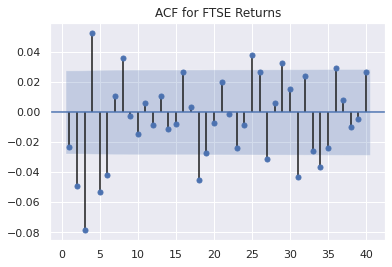

In [74]:
sgt.plot_acf(df_ftse_train['return'], zero=False, lags=40, title='ACF for FTSE Returns'); 
# ACf plots depicts that first lag wont be as significant. The rest until 8th lags are more significant

In [75]:
# 1st data point is removed as it has no previous value
model_ma_1 = ARMA(df_ftse_train['return'][1:], order=(0, 1))        # order = (AR comp, MA comp)
result_ma_1 = model_ma_1.fit()
print(result_ma_1.summary())

# L1 p-val > 0.05 but < 0.1, significant at 10%

                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 5019
Model:                     ARMA(0, 1)   Log Likelihood               -7928.501
Method:                       css-mle   S.D. of innovations              1.174
Date:                Mon, 05 Apr 2021   AIC                          15863.003
Time:                        16:19:36   BIC                          15882.566
Sample:                    01-11-1994   HQIC                         15869.858
                         - 04-05-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0188      0.016      1.165      0.244      -0.013       0.050
ma.L1.return    -0.0258      0.015     -1.721      0.085      -0.055       0.004
                                    Roots   

Find the best lag

In [76]:
model_ma_results = llr_tests_ma(df_ftse_train['return'][1:])
# The result perfectly matches with the trend in ACF plot
# AR(8) is the best model

{2: 0.0, 3: 0.0, 4: 0.001, 5: 0.001, 6: 0.007, 7: 0.551, 8: 0.009, 9: 0.59}


Check for residual

In [77]:
df_ma_8 = model_ma_results[8]
df_ftse_train['residual_return'] = df_ma_8.resid[1:]
print('Mean residual : {:0.3f}'.format(df_ftse_train['residual_return'].mean()))
print('Stand div residual : {:0.3f}'.format(df_ftse_train['residual_return'].std()))

Mean residual : 0.000
Stand div residual : 1.164


Gaussian white-noise - 68%, 98%, 99.7% - normality: data is spread among 1,2,3 std dev away from mean. <br>
Run DF test to check if residual is stationary -> Plot ACF to check if it's white noise

In [78]:
sts.adfuller(df_ftse_train['residual_return'][2:])
# p-val < 0.05, so the residual is stationary

(-70.84179795636139,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '10%': -2.5670767490325597,
  '5%': -2.8621162697870046},
 15681.854119749052)

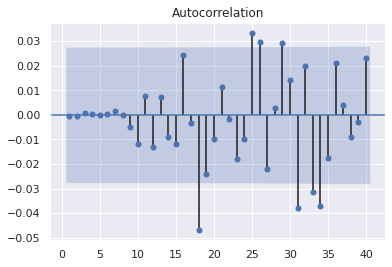

In [79]:
sgt.plot_acf(df_ftse_train['residual_return'][2:], zero=False, lags=40);
# most coeffs are insignificant, so the residual is white noise, especially up to 8th lag

### Extra - MA on Prices

Validate that Prices data can't fit into MA model

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood              -38620.604
Method:                       css-mle   S.D. of innovations            530.681
Date:                Mon, 05 Apr 2021   AIC                          77247.207
Time:                        16:19:47   BIC                          77266.771
Sample:                    01-10-1994   HQIC                         77254.063
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.8818     14.659    347.224      0.000    5061.151    5118.612
ma.L1.market_value     0.9573      0.003    335.390      0.000       0.952       0.963
                    

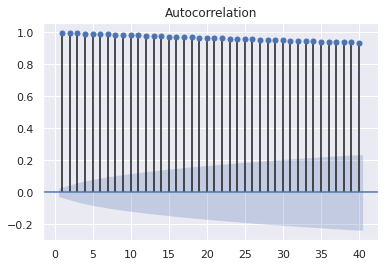

In [80]:
sgt.plot_acf(df_ftse_train['market_value'], zero=False, lags=40);
model = ARMA(df_ftse_train['market_value'], order=(0,1))
result = model.fit()
print(result.summary())

# Higher lag model will always be preferred as all lags are significant, hence MA(infinite) model
# ma.L1 is very close to 1. Model tries to keep almost full magnitude of error term from 1st lag

### 3. ARMA

In [81]:
# ARMA(1,1)
model_arma_1_1 = ARMA(df_ftse_train['return'], order=(1,1))
result_arma_1_1 = model_arma_1_1.fit()
print(result_arma_1_1.summary())

# const p-value > 0.05, so const is insignificant. This is acceptable as return is centered around 0, hence no need for offset.
# positive AR(1). Suggests return moves in trends of consecutive positive -> Persistent increase in prices
# negative MA(1). Suggests prediction should not use 1st lag as target for calibration -> moves past error away from actual value -> prevent target from moving before we encounter them

                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Mon, 05 Apr 2021   AIC                          15841.000
Time:                        16:19:49   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.return     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.return    -0.8141      0.061    -13.40

Validate if ARMA(1) is better than AR(1) & MA(1)

In [82]:
print(llr_test(result_ar_1, result_arma_1_1))
print(llr_test(result_ma_1, result_arma_1_1))
# both p-value < 0.05, so suggests ARMA(1,1) model is better

0.0
0.0


Find best # of lags for ARMA

In [83]:
# from prev findings, AR(6) (from PACF for returns) & MA(8) (from ACF for returns) are the best
# ARMA model should be smaller than (6,8) since AR and MA will compliment one another

# Modeling starts from the most complex one then cross out the redundancy and repeat
# first 8 data points are removed as they don't have prev values in 8 lags

#model_arma_6_8 = ARMA(df_ftse_train['return'][1:], order=(6,8)) 
#result_arma_6_8 = model_arma_6_8.fit()
#print(result_arma_6_8.summary())

# result can't be converged. Let's try half the lags to ARMA(3,3)

In [84]:
model_arma_3_3 = ARMA(df_ftse_train['return'][1:], order=(3,3)) 
result_arma_3_3 = model_arma_3_3.fit()

In [85]:
# Check if ARMA(3,3) is better than ARMA(1, 1)
# deg of freedom = 4 as 3+3 from ARMA(3,3) - 1+1 from ARMA(1,1)
print("log likelihood p-value : {}".format(llr_test(result_arma_1_1, result_arma_3_3, deg_of_freedom=4)))  
print(result_arma_3_3.summary())

# LLR test : ARMA(3,3) > ARMA(1,1)
# L1 for AR & MA > 0.05, so we should go for lower lag model

# best model is between ARMA(1,1) & ARMA(3,3)

log likelihood p-value : 0.0
                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 5019
Model:                     ARMA(3, 3)   Log Likelihood               -7892.414
Method:                       css-mle   S.D. of innovations              1.166
Date:                Mon, 05 Apr 2021   AIC                          15800.828
Time:                        16:19:52   BIC                          15852.996
Sample:                    01-11-1994   HQIC                         15819.109
                         - 04-05-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0190      0.014      1.398      0.162      -0.008       0.046
ar.L1.return    -0.1903      0.104     -1.828      0.068      -0.394       0.014
ar.L2.return   

In [86]:
model_arma_3_2 = ARMA(df_ftse_train['return'][1:], order=(3,2)) 
result_arma_3_2 = model_arma_3_2.fit()
print(result_arma_3_2.summary())
# All coeffs are significant
# coeff decreases as lag is longer. Suggests older values and errors are less relevant

# negative AR coeffs -> every period of positive return is followed by a negative return in dataset with mean = 0 -> 
    # suggests efficient market
    # also shows ARMA is good to estimate stationary data
# positive MA coeffs -> error will be shifted closer to actual value for next prediction

# futher hidden work : ARMA(2,3) has insignificant L2 coeffs  
# so ARMA(3,2) > ARMA(2,3)

                              ARMA Model Results                              
Dep. Variable:                 return   No. Observations:                 5019
Model:                     ARMA(3, 2)   Log Likelihood               -7894.627
Method:                       css-mle   S.D. of innovations              1.166
Date:                Mon, 05 Apr 2021   AIC                          15803.254
Time:                        16:19:55   BIC                          15848.901
Sample:                    01-11-1994   HQIC                         15819.250
                         - 04-05-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0189      0.015      1.255      0.209      -0.011       0.048
ar.L1.return    -0.6786      0.087     -7.800      0.000      -0.849      -0.508
ar.L2.return    -0.5084      0.139     -3.66

In [87]:
def llr_modeling_test(series, lower_order, higher_order, deg_of_freedom=1):
    model_lower_ = ARMA(series, order=lower_order) 
    result_lower = model_lower_.fit()
    model_higher = ARMA(series, order=higher_order) 
    result_higher = model_higher.fit()

    print(llr_test(result_lower, result_higher, deg_of_freedom))

In [88]:
def print_ll_aic(series, order, start_ar_lags=None):
    model = ARMA(series, order=order) 
    result = model.fit(start_ar_lags=start_ar_lags)
    print("({}) - LL:{:.2f}; AIC:{:.2f}".format(order,result.llf, result.aic))

In [89]:
llr_modeling_test(df_ftse_train['return'][1:], (3,1), (3,2))
# ARMA(3,2) > ARMA(3,1) as p-value < 0.05

0.01


In [90]:
llr_modeling_test(df_ftse_train['return'][1:], (2,1), (3,2), deg_of_freedom=2)
# ARMA(3,2) > ARMA(2,1) as p-value < 0.05

0.0


In [91]:
llr_modeling_test(df_ftse_train['return'][1:], (1,2), (3,2), deg_of_freedom=2)
# ARMA(3,2) > ARMA(1,2) as p-value < 0.05

0.0


In [92]:
# ARMA(1,3) & ARMA(3,2) can't be compared with log likelihood ratio test
# Has to manually compare log-likelihoods (higher better) and AIC (lower better) altogether 
print_ll_aic(df_ftse_train['return'][1:], (3,2))
print_ll_aic(df_ftse_train['return'][1:], (1,3))
# ARMA(3,2) > ARMA(1,3)

((3, 2)) - LL:-7894.63; AIC:15803.25
((1, 3)) - LL:-7895.72; AIC:15803.44


Check Residual for our best model, ARMA(3,2)

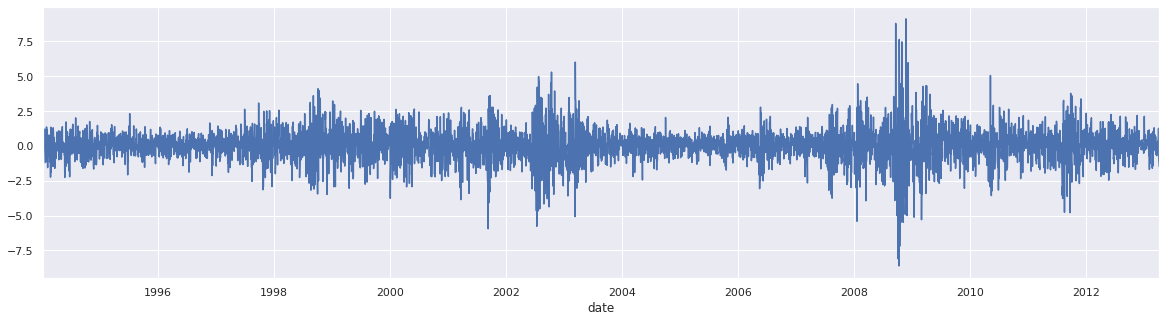

In [93]:
df_ftse_train['result_arma_3_2'] = result_arma_3_2.resid[1:]
df_ftse_train['result_arma_3_2'].plot(figsize=(20,5));
# ARMA residual is similar to AR and MA. Suggests ARMA can't comprehend the return's volatility

Check ACF of residual

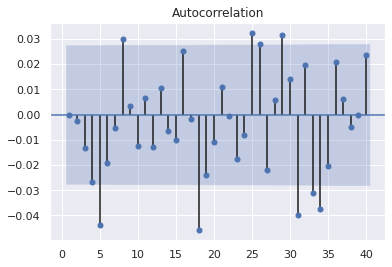

In [94]:
sgt.plot_acf(df_ftse_train['result_arma_3_2'][2:], zero=False, lags=40);
# 5th lag is significant. So getting ARMA(5,y) or ARMA(x,5) might be able to improve the result

# futher hidden work : 
    # explore all ARMA(5,y) and ARMA(x,5), only ARMA(5,1) and ARMA(1,5) has all significant coeff
    # ARMA(5,1) > ARMA(1,5) with higher LL & lower AIC
    # ARMA(3,2) > ARMA(5,1) with higher LL & lower AIC
    # Check with higher order from residual ACF is needed to avoid incorrect starting point
    # we avoid significant lag with higher order, e.g. 18th to avoid over-fitting 

### Extra - ARMA on Prices

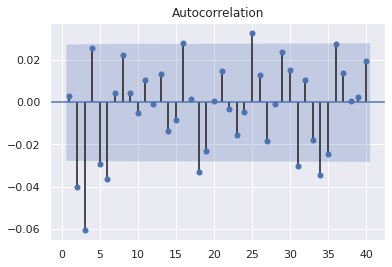

In [95]:
# find residual in ARMA(1,1) & check for ARMA(N,N) to start with
model_arma_1_1_prices = ARMA(df_ftse_train['market_value'], order=(1,1))
results_arma_1_1_prices = model_arma_1_1_prices.fit()
df_ftse_train['residual_arma_1_1_prices'] = results_arma_1_1_prices.resid
sgt.plot_acf(df_ftse_train['residual_arma_1_1_prices'], zero=False, lags=40);

# ARMA(6,6) is a good start

# futher hidden work : 
    # ARMA(6,6) returns initial AR coeff not stationary. 
    # Possible fixes:  
        # induce stationary - transform data into returns
        # use different order - avoid as we want to keep (6,6)
        # customise start_params - e.g. use start_ar_lags = 6 onwards until error is resolved, in this case 11 

In [96]:
model_arma_6_6_prices = ARMA(df_ftse_train['market_value'], order=(6,6))
results_arma_6_6_prices = model_arma_6_6_prices.fit(start_ar_lags=11)
print(results_arma_6_6_prices.summary())
# some of the coeff is insignificant. So we can lower the order

# futher hidden work : 
    # Only ARMA(5,6) & ARMA(6,1) have all significant coeffs
    # ARMA(5,6) > ARMA(6,1) with higher LL & lower AIC  
    # ACF of ARMA(5,6) are insignificant in the first 17 lags, so residuals resemble White Noise

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(6, 6)   Log Likelihood              -27582.934
Method:                       css-mle   S.D. of innovations             58.855
Date:                Mon, 05 Apr 2021   AIC                          55193.867
Time:                        16:20:32   BIC                          55285.164
Sample:                    01-10-1994   HQIC                         55225.859
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9763    569.555      8.937      0.000    3973.670    6206.283
ar.L1.market_value     1.9276      0.032     60.447      0.000       1.865       1.990
ar.L2.market_value  

In [97]:
# Compare LL & AIC between ARMA result with return & price
print_ll_aic(df_ftse_train['return'][1:], (3,2))
print_ll_aic(df_ftse_train['market_value'], (5,6), 11)

# ARMA with return is way better than market_value
# this also verify that ARMA performs better with stationary data

((3, 2)) - LL:-7894.63; AIC:15803.25
((5, 6)) - LL:-27585.96; AIC:55197.92


### ARIMA

In [98]:
# manual work to check if stationarity is achieved after integration
df_ftse_train['delta_prices'] = df_ftse_train['market_value'].diff(1) # the difference between data point and its 1 pervious data point = 1 integration
sts.adfuller(df_ftse_train['delta_prices'][1:])
# test statistics value (-32.2) < 5% critical value (-2.86) & p-value (0.0) < 0.05, so it's stationary

(-32.23894310693136,
 0.0,
 5,
 5013,
 {'1%': -3.431655136974821,
  '10%': -2.567076993884522,
  '5%': -2.8621167297421373},
 54834.31732499655)

In [99]:
model_arima_1_1_1 = ARIMA(df_ftse_train['market_value'], order=(1,1,1))
result_arima_1_1_1 = model_arima_1_1_1.fit()
print(result_arima_1_1_1.summary())
# result resembles closer to return than market_value, both used in ARMA(1,1).

                             ARIMA Model Results                              
Dep. Variable:         D.market_value   No. Observations:                 5019
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27598.660
Method:                       css-mle   S.D. of innovations             59.139
Date:                Mon, 05 Apr 2021   AIC                          55205.320
Time:                        16:20:55   BIC                          55231.404
Sample:                    01-11-1994   HQIC                         55214.460
                         - 04-05-2013                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5667      0.682      0.830      0.406      -0.771       1.904
ar.L1.D.market_value     0.7474      0.070     10.648      0.000       0.610       0.885
ma.L1.D.mark

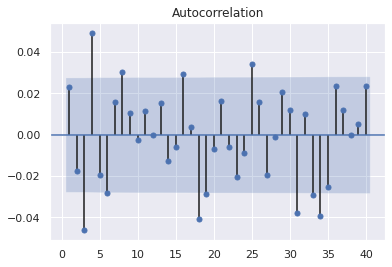

In [100]:
sgt.plot_acf(result_arima_1_1_1.resid, zero=False, lags=40); 
# first 4 lags seem significant

# futher hidden work : 
    # Test from ARIMA(4,1,4) to ARIMA(1,1,1) & check coeff significance
    # Only (1,1,2), (1,1,3), (2,1,1), (3,1,1), (3,1,2) yield significant coeffs
    # comapare results via LLR test or LL&AIC test
    # conclusion : 
        # ARIMA(1,1,3) has the highest LL & lowest AIC
        # ARIMA(1,1,3) also > ARIMA(1,1,2) with p-value < 0.05 in LLR test 

                             ARIMA Model Results                              
Dep. Variable:         D.market_value   No. Observations:                 5019
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -27585.412
Method:                       css-mle   S.D. of innovations             58.983
Date:                Mon, 05 Apr 2021   AIC                          55182.823
Time:                        16:20:57   BIC                          55221.949
Sample:                    01-11-1994   HQIC                         55196.534
                         - 04-05-2013                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5669      0.723      0.784      0.433      -0.850       1.984
ar.L1.D.market_value    -0.3586      0.124     -2.881      0.004      -0.603      -0.115
ma.L1.D.mark

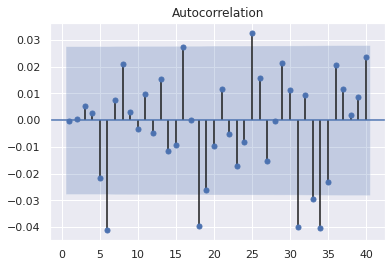

In [101]:
model_arima_1_1_3 = ARIMA(df_ftse_train['market_value'], order=(1,1,3))
result_arima_1_1_3 = model_arima_1_1_3.fit()
print(result_arima_1_1_3.summary())
sgt.plot_acf(result_arima_1_1_3.resid, zero=False, lags=40); 

# Based on ACF, we have to also check ARIMA(6,1,6)
# futher hidden work : 
    # Only ( 6,1,3), (5,1,1) yield significant coeffs
    # from our previous finding, ARMA(5,1) is also the preferred model
    # After comaparing (1,1,3), ( 6,1,3), (5,1,1) via LLR test & LL&AIC test, (5,1,1) is the best 

                             ARIMA Model Results                              
Dep. Variable:         D.market_value   No. Observations:                 5019
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -27581.503
Method:                       css-mle   S.D. of innovations             58.937
Date:                Mon, 05 Apr 2021   AIC                          55179.007
Time:                        16:20:59   BIC                          55231.174
Sample:                    01-11-1994   HQIC                         55197.287
                         - 04-05-2013                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5680      0.691      0.822      0.411      -0.785       1.921
ar.L1.D.market_value     0.4009      0.159      2.527      0.011       0.090       0.712
ar.L2.D.mark

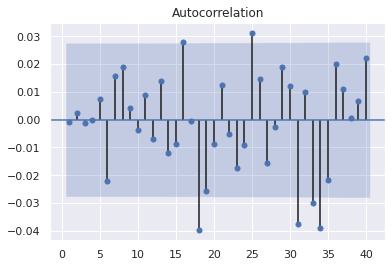

In [102]:
model_arima_5_1_1 = ARIMA(df_ftse_train['market_value'], order=(5,1,1))
result_arima_5_1_1 = model_arima_5_1_1.fit()
print(result_arima_5_1_1.summary())
sgt.plot_acf(result_arima_5_1_1.resid, zero=False, lags=40); 

# no significant correlation in first 15 lags, perfect.

### ARIMAX

In [103]:
df_ftse_train['spx'] = df_spx_train['spx']
df_ftse_train

,market_value,return,norm_return,residual_return,result_arma_3_2,residual_arma_1_1_prices,delta_prices,spx
date,,,,,,,,
1994-01-10,3440.58,-0.156704,100.000000,NaN,NaN,-1615.146470,NaN,475.270000
1994-01-11,3413.77,-0.779229,497.260711,NaN,NaN,-29.272556,-26.81,474.130000
1994-01-12,3372.02,-1.222988,780.443046,-1.260039,-1.260326,-44.715526,-41.75,474.170000
1994-01-13,3360.01,-0.356166,227.285567,-0.443860,-0.445086,-15.331103,-12.01,472.470000
1994-01-14,3400.56,1.206842,-770.139292,1.048213,1.056259,37.770968,40.55,474.910000
...,...,...,...,...,...,...,...,...
2013-04-01,6411.74,0.000000,-0.000000,-0.028616,-0.024264,2.036092,0.00,1562.173837
2013-04-02,6490.66,1.230867,-785.471020,1.269050,1.243687,80.947577,78.92,1570.252238
2013-04-03,6420.28,-1.084327,691.957459,-1.088306,-1.098656,-66.733647,-70.38,1553.686978


In [104]:
model_arimax_1_1_1_spx = ARIMA(df_ftse_train['market_value'], exog=df_ftse_train['spx'], order=(1,1,1)) 
result_arimax_1_1_1_spx = model_arimax_1_1_1_spx.fit()
print(result_arimax_1_1_1_spx.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.market_value   No. Observations:                 5019
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27598.551
Method:                       css-mle   S.D. of innovations             59.138
Date:                Mon, 05 Apr 2021   AIC                          55207.102
Time:                        16:21:02   BIC                          55239.707
Sample:                    01-11-1994   HQIC                         55218.527
                         - 04-05-2013                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6286      2.657     -0.237      0.813      -5.836       4.579
spx                      0.0011      0.002      0.466      0.642      -0.004       0.006
ar.L1.D.mark

### SARIMAX

In [105]:
# SARIMAX(1,0,1)(2,0,1,5)
model_sarimax_101_2015_spx = SARIMAX(df_ftse_train['market_value'], exog=df_ftse_train['spx'], order=(1,0,1), seasonal_order=(2,0,1,5)) 
result_sarimax_101_2015_spx = model_sarimax_101_2015_spx.fit()
print(result_sarimax_101_2015_spx.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      market_value   No. Observations:                 5020
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26706.929
Date:                           Mon, 05 Apr 2021   AIC                          53427.858
Time:                                   16:21:22   BIC                          53473.506
Sample:                               01-10-1994   HQIC                         53443.854
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7049      0.035     76.377      0.000       2.636       2.774
ar.L1          0.9997      0.001   1787.286

### ARCH

In [106]:
df_ftse_train['return_sq'] = df_ftse_train['return'] ** 2

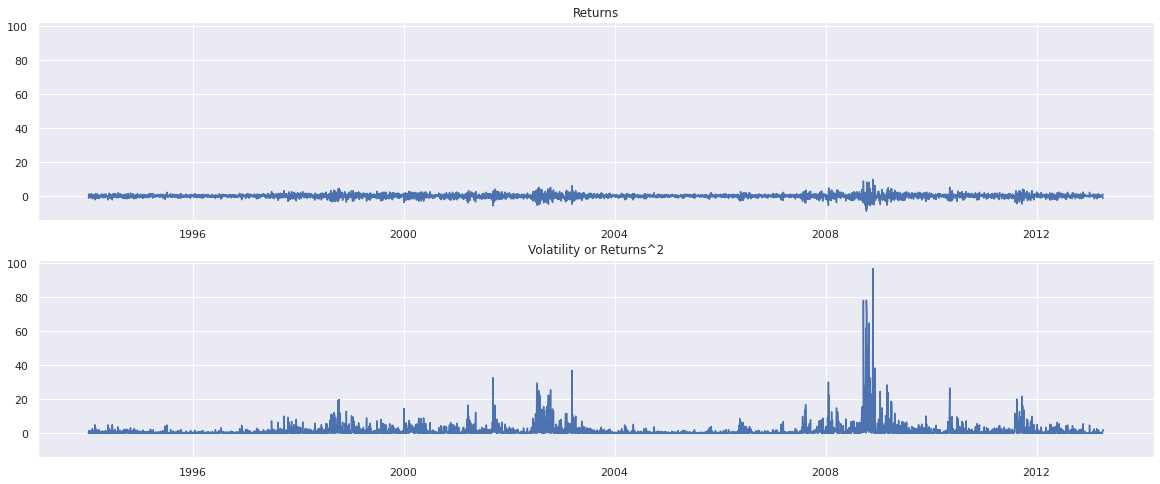

In [107]:
fig, axes = plt.subplots(2,1, figsize=(20,8), sharey=True)

axes[0].plot(df_ftse_train['return'])
axes[0].set_title('Returns')
axes[1].plot(df_ftse_train['return_sq'])
axes[1].set_title('Volatility or Returns^2')
plt.show();
# huge jumps/drops are emphasized in return^2

Find starting order with PACF plot of Return^2

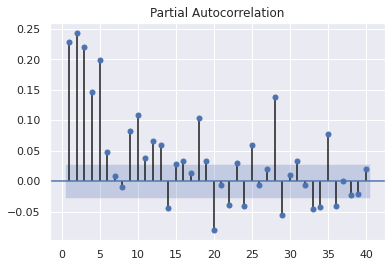

In [108]:
sgt.plot_pacf(df_ftse_train['return_sq'][1:], lags=40, alpha=0.05, zero=False, method=('ols'));
# Start from ARCH(6)
# high correlation in first 5 lags suggests short term trends in variance. High/low variation followed by another high/low variation correspondingly

In [109]:
# ARCH(1)
model_arch_1 = arch_model(df_ftse_train['return'][1:], mean='Constant', vol='ARCH', p=1)  # P = order of ARCH
result_arch_1 = model_arch_1.fit(update_freq = 5)   # to hide iterations from presenting on summary table
print(result_arch_1.summary())  
# Distribution (of residual) : normal  
# Only 5 iterations. Iteration will stop when LLF decreases
# R2 = 0 as every value in residual is decreased by a constant to original dataset
# deg of freedom = 3 : Const (mu) from normal equation + Const (omega) & L1 (alpha[1]) from variance equation

# ARCH(1) LL is higher than -7889 from ARMA(5,1) & -27586 from ARIMA(5,1,1) so far.
# but ARCH can only predict stability as it predicts future variance rather than return 

# Further hidden work:
    # gradually increase p by 1 until one of the coeff is insignificant
    # ARCH(12) is the optimal

Iteration:      5,   Func. Count:     34,   Neg. LLF: 7659.120555443904
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7659.120548122352
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7659.12
Distribution:                  Normal   AIC:                           15324.2
Method:            Maximum Likelihood   BIC:                           15343.8
                                        No. Observations:                 5019
Date:                Mon, Apr 05 2021   Df Residuals:                     5018
Time:                        16:21:23   Df Model:                            1
         

In [110]:
model_arch_tmp = arch_model(df_ftse_train['return'][1:], 
                            mean='AR', lags=[2,3,6],
                            vol='ARCH', p=1, dist='t')  # P = order of ARCH
result_arch_tmp = model_arch_tmp.fit(update_freq = 5)   # to hide iterations from presenting on summary table
print(result_arch_tmp.summary())  
# example for other params

Iteration:      5,   Func. Count:     58,   Neg. LLF: 7344.1478858596865
Iteration:     10,   Func. Count:    110,   Neg. LLF: 7328.312004371135
Iteration:     15,   Func. Count:    155,   Neg. LLF: 7326.413654877071
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7326.413529923272
            Iterations: 16
            Function evaluations: 164
            Gradient evaluations: 16
                              AR - ARCH Model Results                               
Dep. Variable:                       return   R-squared:                       0.007
Mean Model:                              AR   Adj. R-squared:                  0.007
Vol Model:                             ARCH   Log-Likelihood:               -7326.41
Distribution:      Standardized Student's t   AIC:                           14666.8
Method:                  Maximum Likelihood   BIC:                           14712.5
                                              No. Observations

### GARCH

In [111]:
# GARCH(1,1)
model_garch_1_1 = arch_model(df_ftse_train['return'][1:], mean="Constant",
                             vol="GARCH", p=1, q=1)
result_garch_1_1 = model_garch_1_1.fit(update_freq=5)
print(result_garch_1_1)
# higher LLF, better than ARCH(1)

# for market returns, GARCH(1,1) will always perform better than higher order as variance 2 days ago should be explained by yesterday due to volatility cluster
# so there is no need to fit higher order GARCH model

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6971.945567694938
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6969.30718748389
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6969.27754219529
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6969.28
Distribution:                  Normal   AIC:                           13946.6
Method:            Maximum Likelihood   BIC:                           13972.6
                                        No. Observations:                 5019
Date:                Mon, Apr 05 2021   Df Residuals:                     5018
Time:           

## Auto ARIMA

In [112]:
data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", 
                          start = "1994-01-07", end = "2018-01-29",
                          interval = "1d", group_by = 'ticker', 
                          auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [113]:
df = data.copy()
df['spx'] = df['^GSPC'].Close[:]
df['dax'] = df['^GDAXI'].Close[:]
df['ftse'] = df['^FTSE'].Close[:]
df['nikkei'] = df['^N225'].Close[:]
del df['^N225']
del df['^GSPC']
del df['^GDAXI']
del df['^FTSE']

df = df.iloc[1:] 
df = df.asfreq('b')
df = df.fillna(method='ffill')

df['return_spx'] = df['spx'].pct_change(1)*100
df['return_ftse'] = df['ftse'].pct_change(1)*100
df['return_dax'] = df['dax'].pct_change(1)*100
df['return_nikkei'] = df['nikkei'].pct_change(1)*100

SPLIT = 0.8
idx_split = int(df.shape[0] * SPLIT)
df_train, df_test = df.iloc[:idx_split], df.iloc[idx_split:]

In [114]:
# SARIMAX is auto_arima's default best model
model_autoArima = auto_arima(df_train['return_ftse'][1:])
print(model_autoArima)
print(model_autoArima.summary())

# ARMA(2,5) is selected
# Model only optimize by AIC, so insignificant coeff can exist in final model

 ARIMA(2,0,5)(0,0,0)[0]          
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5019
Model:               SARIMAX(2, 0, 5)   Log Likelihood               -7885.535
Date:                Mon, 05 Apr 2021   AIC                          15787.070
Time:                        16:24:55   BIC                          15839.238
Sample:                             0   HQIC                         15805.351
                               - 5019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1761      0.039      4.535      0.000       0.100       0.252
ar.L2         -0.8130      0.035    -22.993      0.000      -0.882      -0.744
ma.L1         -0.1

In [115]:
# exogenous data should be the same type as endogenous, i.e. return_ftse because mixing stationary with non-stationary data can lead to misleading result
# m - length of cycle = frequency , i.e. business days, so = 5
# max_order =  p (AR) + q (MA)
# max_d = 2 usually is enough
# by default, max_P,Q,D are 2,2,1. Set a fiold higher to loosen it up.
# n_jobs = -1 : max # of jobs possibly
# trend = 'ct' : constant trend for LLR test
# information_criteon = 'oob' : out of bag -> for scoring validation
# out of sample : split validaiton set out for oob method
# change dataset to full one instead of train set as we are doing validation
model_autoArima = auto_arima(df['return_ftse'][1:], 
                             exogenous = df[['return_spx', 'return_dax', 'return_nikkei']][1:], 
                             m = 5, max_order = None, 
                             max_p = 7, max_q = 7, max_d = 2, 
                             max_P = 4, max_Q = 4, max_D = 2, 
                             maxiter = 50, alpha = 0.05, n_jobs = -1, 
                             trend = 'ct', information_criterion = 'oob', 
                             out_of_sample = int(len(df)*0.2))
print(model_autoArima)
print(model_autoArima.summary())
# SARIMA(0,0,1)(0,0,4,5) has higher LL

 ARIMA(0,0,1)(0,0,4)[5]          
                                          SARIMAX Results                                           
Dep. Variable:                                            y   No. Observations:                 6275
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2, 3, 4], 5)   Log Likelihood               -6333.370
Date:                                      Mon, 05 Apr 2021   AIC                          12688.740
Time:                                              16:32:16   BIC                          12762.928
Sample:                                          01-11-1994   HQIC                         12714.445
                                               - 01-29-2018                                         
Covariance Type:                                        opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

# Forecast

### Data PreProcessing

In [116]:
data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", 
                          start = "1994-01-07", end = "2019-09-01",
                          interval = "1d", group_by = 'ticker', 
                          auto_adjust = True, treads = True)

df = data.copy()
df['spx'] = df['^GSPC'].Close[:]
df['dax'] = df['^GDAXI'].Close[:]
df['ftse'] = df['^FTSE'].Close[:]
df['nikkei'] = df['^N225'].Close[:]
del df['^N225']
del df['^GSPC']
del df['^GDAXI']
del df['^FTSE']

df = df.iloc[1:] 
df = df.asfreq('b')
df = df.fillna(method='ffill')

df['return_spx'] = df['spx'].pct_change(1)*100
df['return_ftse'] = df['ftse'].pct_change(1)*100
df['return_dax'] = df['dax'].pct_change(1)*100
df['return_nikkei'] = df['nikkei'].pct_change(1)*100
df['norm_ret_spx'] = df['return_spx'].div(df['return_spx'][1])*100
df['norm_ret_ftse'] = df['ftse'].div(df['return_spx'][1])*100
df['norm_ret_dax'] = df['dax'].div(df['return_spx'][1])*100
df['norm_ret_nikkei'] = df['nikkei'].div(df['return_spx'][1])*100

SPLIT = 0.8
idx_split = int(df.shape[0] * SPLIT)
df_train, df_test = df.iloc[:idx_split], df.iloc[idx_split:]

[*********************100%***********************]  4 of 4 completed


In [117]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

In [118]:
print(df_train.tail(1).index)
# Prediction starts on 2014-07-16

DatetimeIndex(['2014-07-15'], dtype='datetime64[ns]', name='Date', freq='B')


In [119]:
start_date = '2014-07-16'
end_date = '2015-01-01'

## AR - Price

In [120]:
model_ar_1 = ARIMA(df_train['ftse'], order=(1,0,0))
result_ar_1 = model_ar_1.fit() 
df_pred = result_ar_1.predict(start=start_date, end=end_date)

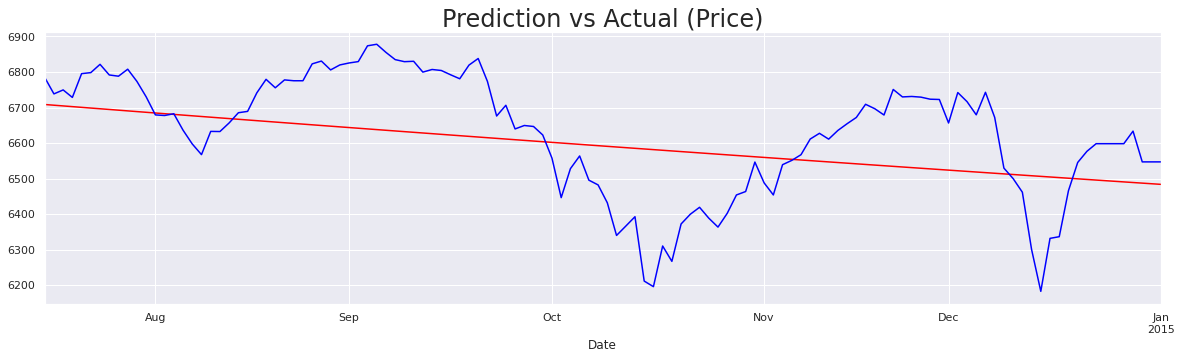

In [122]:
df_pred[start_date:end_date].plot(figsize=(20,5), color='red');
df_test['ftse'][start_date:end_date].plot(figsize=(20,5), color='blue');
plt.title("Prediction vs Actual (Price)", size=24)
plt.plot();
# A small curve (when zoomed out / extend end date) is not realistic.
# Happens because the model only based on a consts and a previous price
# So AR model is not suitable for non-stationary data

## AR - Return

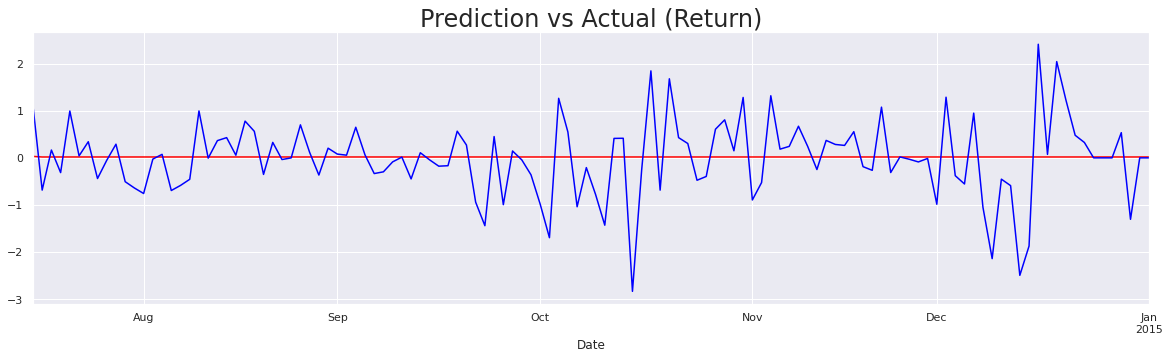

In [123]:
model_ar_1 = ARIMA(df_train['return_ftse'][1:], order=(1,0,0))
result_ar_1 = model_ar_1.fit() 

df_pred = result_ar_1.predict(start=start_date, end=end_date)
df_pred[start_date:end_date].plot(figsize=(20,5), color='red');
df_test['return_ftse'][start_date:end_date].plot(figsize=(20,5), color='blue');
plt.title("Prediction vs Actual (Return)", size=24)
plt.plot();
# AR(1) makes no prediction

## MA

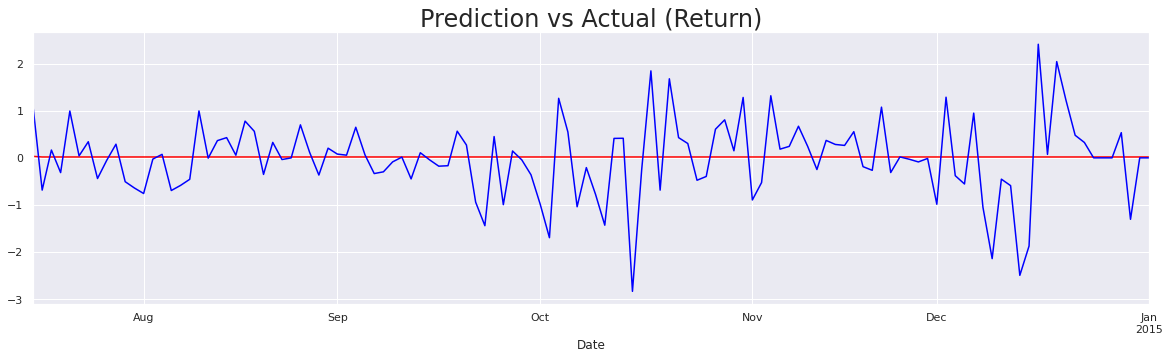

In [124]:
model_ma_1 = ARIMA(df_train['return_ftse'][1:], order=(0,0,1))
result_ma_1 = model_ma_1.fit() 

df_pred = result_ma_1.predict(start=start_date, end=end_date)
df_pred[start_date:end_date].plot(figsize=(20,5), color='red');
df_test['return_ftse'][start_date:end_date].plot(figsize=(20,5), color='blue');
plt.title("Prediction vs Actual (Return)", size=24)
plt.plot();
# MA(1) makes no prediction too

## ARMAX

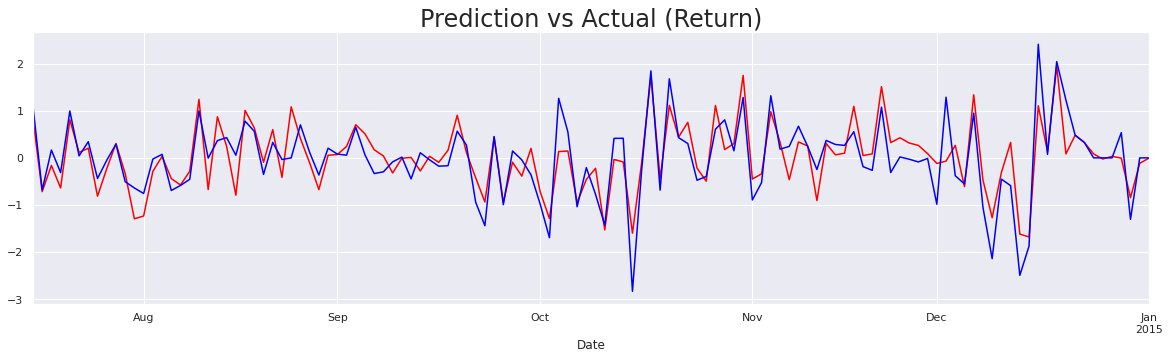

In [125]:
model_armax_1_1 = ARIMA(df_train['return_ftse'][1:], 
                         exog=df_train[['return_spx','return_dax','return_nikkei']][1:], 
                         order=(1,0,1))
result_armax_1_1 = model_armax_1_1.fit() 

# Exog in prediciton has to come form test set & no need to remove first row of test set as it holds value
df_pred = result_armax_1_1.predict(start=start_date, end=end_date,
                                   exog=df_test[['return_spx','return_dax','return_nikkei']][start_date:end_date])

df_pred[start_date:end_date].plot(figsize=(20,5), color='red');
df_test['return_ftse'][start_date:end_date].plot(figsize=(20,5), color='blue');
plt.title("Prediction vs Actual (Return)", size=24)
plt.plot();
# much better but -X model involves exog data points which is out of train set
# so it's impossible to do forecasting for unseen future values
# Can be great for data analysis for poor for data forecasting

## SARMA

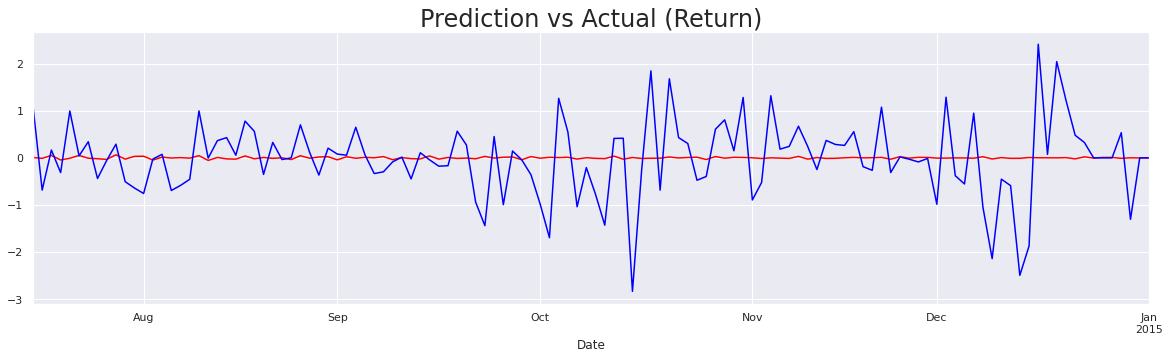

In [126]:
model_sarma_304_3025 = SARIMAX(df_train['return_ftse'][1:], order=(3,0,4), seasonal_order=(3,0,2,5))
result_sarma_304_3025 = model_sarma_304_3025.fit() 

df_pred = result_sarma_304_3025.predict(start=start_date, end=end_date)
df_pred[start_date:end_date].plot(figsize=(20,5), color='red');
df_test['return_ftse'][start_date:end_date].plot(figsize=(20,5), color='blue');
plt.title("Prediction vs Actual (Return)", size=24)
plt.plot();

## SARMAX

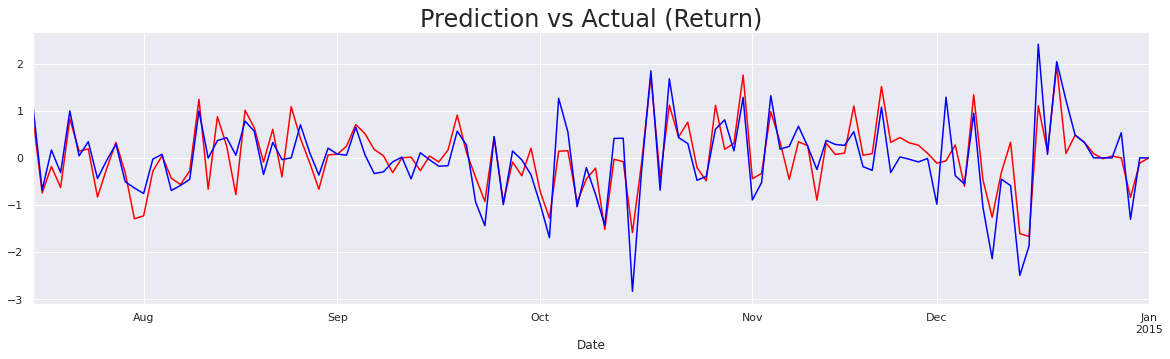

In [127]:
model_sarmax_304_3025 = SARIMAX(df_train['return_ftse'][1:], 
                         exog=df_train[['return_spx','return_dax','return_nikkei']][1:], 
                         order=(3,0,4), seasonal_order=(3,0,2,5))
result_sarmax_304_3025 = model_sarmax_304_3025.fit() 

# Exog in prediciton has to come form test set & no need to remove first row of test set as it holds value
df_pred = result_sarmax_304_3025.predict(start=start_date, end=end_date,
                                   exog=df_test[['return_spx','return_dax','return_nikkei']][start_date:end_date])

df_pred[start_date:end_date].plot(figsize=(20,5), color='red');
df_test['return_ftse'][start_date:end_date].plot(figsize=(20,5), color='blue');
plt.title("Prediction vs Actual (Return)", size=24)
plt.plot();
# much better but -X model involves exog data points which is out of train set
# so it's impossible to do forecasting for unseen future values
# Can be great for data analysis for poor for data forecasting

## Auto-ARIMA (default)



In [128]:
model_auto = auto_arima(df_train['return_ftse'][1:]) 
df_test_val = df_test[start_date:end_date]

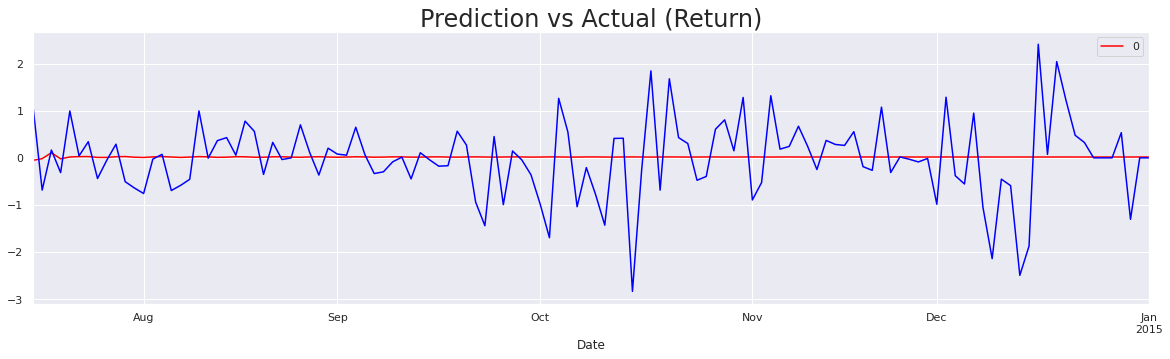

In [129]:
df_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test_val)), 
                                         index=df_test_val.index)
df_pred.plot(figsize=(20,5), color='red');
df_test['return_ftse'][start_date:end_date].plot(figsize=(20,5), color='blue');
plt.title("Prediction vs Actual (Return)", size=24)
plt.plot();

## Auto-ARIMA (improved)

In [130]:
model_auto = auto_arima(df_train['return_ftse'][1:], exogenous = df_train[['return_spx','return_dax','return_nikkei']][1:],
                        m=5, max_p=5, max_q=5, max_P=5, max_Q=5) 
df_test_val = df_test[start_date:end_date]


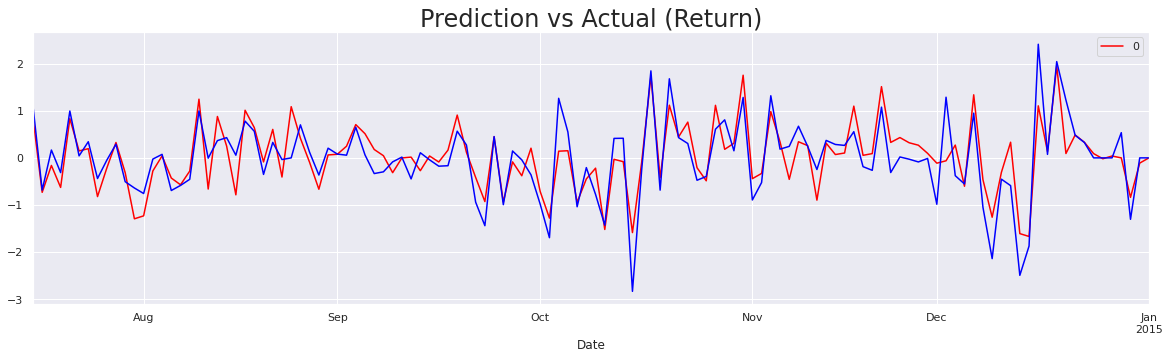

In [131]:
df_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test_val),
                                          exogenous=df_test[['return_spx','return_dax','return_nikkei']][start_date:end_date]),
                       index=df_test_val.index)
df_pred[start_date:end_date].plot(figsize=(20,5), color='red');
df_test['return_ftse'][start_date:end_date].plot(figsize=(20,5), color='blue');
plt.title("Prediction vs Actual (Return)", size=24)
plt.plot();

## GARCH

In [132]:
model_garch_1_1 = arch_model(df['return_ftse'][1:], vol='GARCH', p=1, q=1, 
                             mean='constant', dist='Normal')
result_garch_1_1 = model_garch_1_1.fit(last_obs = start_date, update_freq=10 )

Iteration:     10,   Func. Count:     74,   Neg. LLF: 7311.064967249472
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7311.064229906422
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


1 day ahead

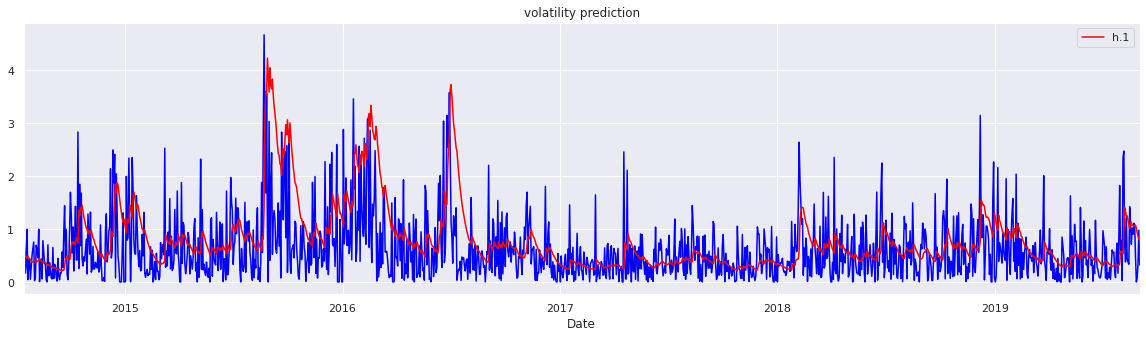

In [139]:
# horizon = # days predicted ahead for each day
# align = match value with the date the prediction is made or the one it's supposed to represent
pred_garch_1_1 = result_garch_1_1.forecast(horizon=1, align='target') 
pred_garch_1_1.residual_variance[start_date:].plot(figsize=(20,5), 
                                                           color='red', 
                                                           title="volatility prediction",
                                                           zorder=2);
df_test['return_ftse'].abs().plot(color='blue', zorder=1);
plt.plot();

# prediction is done only on test set rather than forecasting the future

100 days ahead

In [141]:
pred_garch_1_1 = result_garch_1_1.forecast(horizon=100, align='target') 
pred_garch_1_1.residual_variance[-1:]       # show the volatility of only 100 days of forecast from the last day


,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,h.011,h.012,h.013,h.014,h.015,h.016,h.017,h.018,h.019,h.020,h.021,h.022,h.023,h.024,h.025,h.026,h.027,h.028,h.029,h.030,h.031,h.032,h.033,h.034,h.035,h.036,h.037,h.038,h.039,h.040,...,h.061,h.062,h.063,h.064,h.065,h.066,h.067,h.068,h.069,h.070,h.071,h.072,h.073,h.074,h.075,h.076,h.077,h.078,h.079,h.080,h.081,h.082,h.083,h.084,h.085,h.086,h.087,h.088,h.089,h.090,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811449,0.805648,0.867232,0.940608,1.02073,1.084989,1.074064,1.067783,1.08121,1.090608,1.142407,1.121338,1.036393,1.11072,1.183629,1.257723,1.248608,1.336788,1.395024,1.014502,0.65149,0.691586,0.683082,0.701209,0.509165,0.491619,0.510821,0.490371,0.49208,0.512208,0.531597,0.528003,0.524606,0.523109,0.536405,0.555709,0.569648,0.590162,0.609764,0.63289,...,0.779928,0.790801,0.816335,0.836243,0.860533,0.85355,0.873285,0.827,0.8511,0.878126,0.888177,0.808246,0.829919,0.85095,0.859692,0.883821,0.883548,0.883613,0.855375,0.8605,0.882306,0.865465,0.886742,0.777604,0.790476,0.798239,0.800314,0.802961,0.810827,0.823701,0.837281,0.838888,0.830292,0.815455,0.827095,0.839331,0.850645,0.864163,0.871725,0.886197


## VARMA / Vector SARIMAX
Mutivariate Auto-Regression

In [153]:
df_returns = df_train[['return_spx','return_dax','return_ftse','return_nikkei']][1:]
model_var_return = VAR(df_returns)
model_var_return.select_order(20)   # maximum order from the sum order of each vector
results_var_return = model_var_return.fit(ic='aic')
print(results_var_return.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     17:44:19
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.330716
Nobs:                     5346.00    HQIC:                  0.263399
Log likelihood:          -30866.1    FPE:                    1.25516
AIC:                     0.227263    Det(Omega_mle):         1.23563
--------------------------------------------------------------------
Results for equation return_spx
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.039150         0.016160            2.423           0.015
L1.return_spx           -0.110568         0.017558           -6.297           0.000
L1.return_dax            0.065289         0

[]

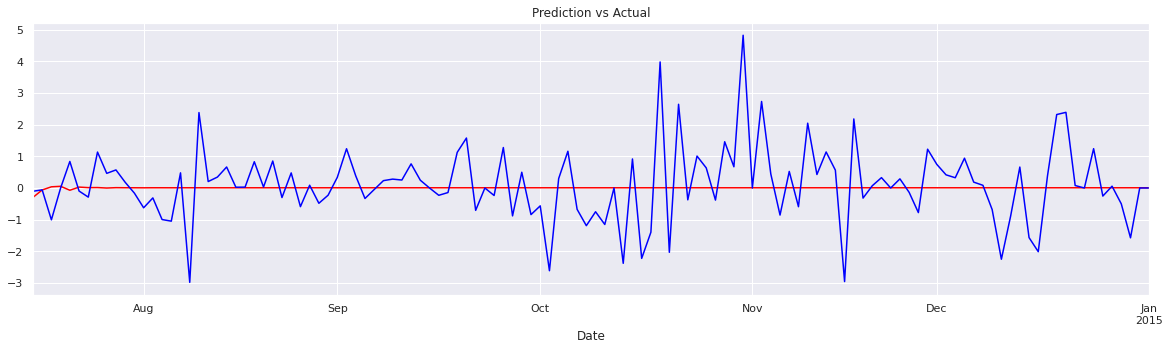

In [154]:
lag_num = results_var_return.k_ar      # extract # of lag decided by the model
pred_var_return = results_var_return.forecast(df_returns.values[-lag_num:], len(df_test[start_date:end_date]))

df_return_pred = pd.DataFrame(data=pred_var_return, index=df_test[start_date:end_date].index,
                              columns=df_test[start_date:end_date].columns[4:8])

df_return_pred['return_nikkei'][start_date:end_date].plot(figsize=(20,5), color='red',
                                                          title='Prediction vs Actual')
df_test['return_nikkei'][start_date:end_date].plot(color="blue")
plt.plot()

# Like AR model as it only fit past data into the model

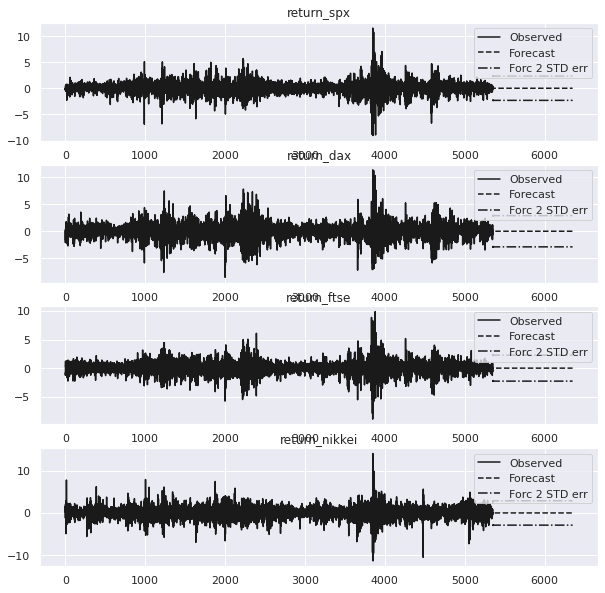

In [155]:
results_var_return.plot_forecast(1000);

# Case Study : Volkswagen buyout of Porsche
To examine prices are affected by the event of Porsche buyout by VW.<br>
Also try to predict prices in between announcements as compared to the prices prior to first announcement with Porsche & BMW (market benchmark) prices

## Load Data & PreProcessing

In [156]:
# Use BMW as market benchmark to make sure a;; changes in value are stock specific 
data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", 
                          interval = "1d", group_by = 'ticker', 
                          auto_adjust = True, treads = True)

start_date = '2009-04-05'
ann1_date = '2009-12-09'    # VW announced owning 49.9% of Porsche
ann2_date = '2012-07-05'    # made purchase of the remaining 50.1% of Porsche
end_date = '2014-01-01'     # opt for a day not too long away from 2nd announcement to keep it relevant
dieselGate_date = '2015-09-20'  # dieselgate scandal

[*********************100%***********************]  3 of 3 completed


In [160]:
df = data.copy()

df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

df['return_vol'] = df['vol'].pct_change(1)*100
df['return_por'] = df['por'].pct_change(1)*100
df['return_bmw'] = df['bmw'].pct_change(1)*100

df['ret_sq_vol'] = df['return_vol']**2
df['ret_sq_por'] = df['return_por']**2
df['ret_sq_bmw'] = df['return_bmw']**2

# quantity traded each day
# higher quantity traded = more likely for stock price to fluctuate
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

df = df.asfreq('b')
df = df.fillna(method='bfill')

del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

# no need for train-test split as we are not predicting the future

## Data Analysis

[]

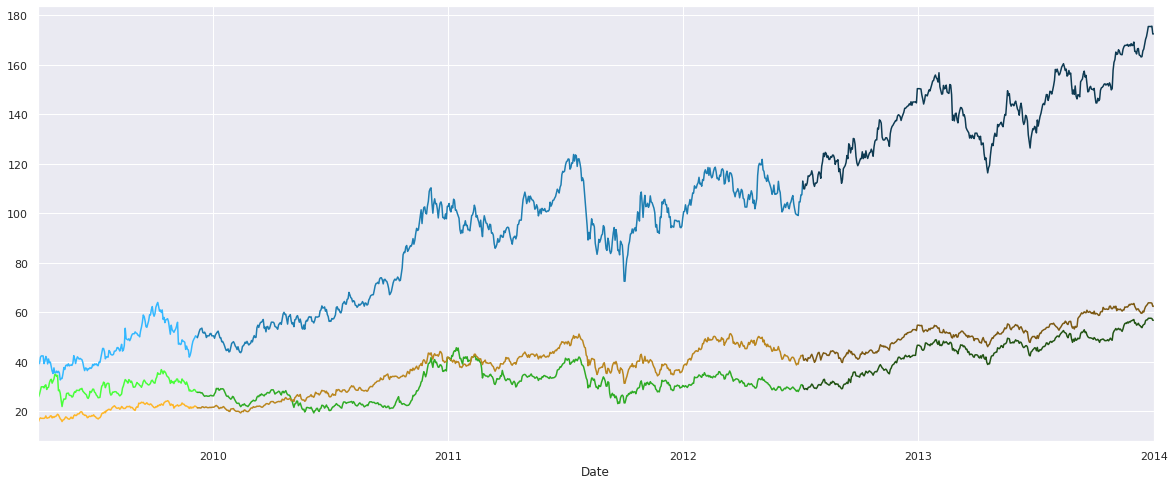

In [162]:
df['vol'][start_date:ann1_date].plot(figsize=(20,8), color='#33B8FF');
df['por'][start_date:ann1_date].plot(figsize=(20,8), color='#49FF3A');
df['bmw'][start_date:ann1_date].plot(figsize=(20,8), color='#FEB628');

df['vol'][ann1_date:ann2_date].plot(figsize=(20,8), color='#1E7EB2');
df['por'][ann1_date:ann2_date].plot(figsize=(20,8), color='#2FAB25');
df['bmw'][ann1_date:ann2_date].plot(figsize=(20,8), color='#BA861F');

df['vol'][ann2_date:end_date].plot(figsize=(20,8), color='#0E3A52');
df['por'][ann2_date:end_date].plot(figsize=(20,8), color='#225414');
df['bmw'][ann2_date:end_date].plot(figsize=(20,8), color='#7C5913');
plt.plot()

# BMW price trend resembles Prosche much more compared to VW

In [165]:
df[['vol','por','bmw']][start_date:end_date].corr()
# VMW trends more similarly to market benchmark, i.e. BMW , generally  

,,vol,por,bmw
,,,,
vol,,1.000000,0.835955,0.979938
por,,0.835955,1.000000,0.805216
bmw,,0.979938,0.805216,1.000000


In [166]:
df[['vol','por','bmw']][start_date:ann1_date].corr()
# So before first buyout, Prices between VW and Porche trend less similarly

,,vol,por,bmw
,,,,
vol,,1.000000,0.663358,0.842761
por,,0.663358,1.000000,0.609504
bmw,,0.842761,0.609504,1.000000


In [167]:
df[['vol','por','bmw']][ann1_date:ann2_date].corr()
# correlation increases as BMW (indirectly) and Porsche (directly) adjust to the market trendsetter, i.e. VW

,,vol,por,bmw
,,,,
vol,,1.000000,0.742827,0.979594
por,,0.742827,1.000000,0.704272
bmw,,0.979594,0.704272,1.000000


In [168]:
df[['vol','por','bmw']][ann2_date:end_date].corr()
# Porsche trended much similarly to VW as compared to BMW after VW fully acquire Porsche

,,vol,por,bmw
,,,,
vol,,1.000000,0.940524,0.928445
por,,0.940524,1.000000,0.949411
bmw,,0.928445,0.949411,1.000000


In [169]:
# Price trend comparison after 2nd announcement
df[['vol','por','bmw']][end_date:].corr()
# We can see Porsche and VW are highly correlated until today
# Also, VW seems not the trendsetter any more, possibly due to the Dieselgate scandal

,,vol,por,bmw
,,,,
vol,,1.000000,0.964271,0.553783
por,,0.964271,1.000000,0.533547
bmw,,0.553783,0.533547,1.000000


## Modeling

In [172]:
# Pre-buyout
mod_pr_pre_vol = auto_arima(df['vol'][start_date:ann1_date], exogenous = df[['por','bmw']][start_date:ann1_date],
                            m = 5, max_p = 5, max_q = 5)
# Between-buyout
mod_pr_btn_vol = auto_arima(df['vol'][ann1_date:ann2_date], exogenous = df[['por','bmw']][ann1_date:ann2_date],
                            m = 5, max_p = 5, max_q = 5)
# Post-buyout
mod_pr_post_vol = auto_arima(df['vol'][ann2_date:end_date], exogenous = df[['por','bmw']][ann2_date:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [176]:
print(mod_pr_pre_vol.summary())
# ar.L1 is almost = 1 : very little deviation as time passes

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -327.180
Date:                Mon, 05 Apr 2021   AIC                            664.360
Time:                        18:43:29   BIC                            680.269
Sample:                    04-06-2009   HQIC                           670.811
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7404      0.458      1.618      0.106      -0.157       1.637
por            0.3997      0.096      4.169      0.000       0.212       0.588
bmw            0.6763      0.321      2.107      0.0

In [179]:
print(mod_pr_btn_vol.summary())
# integrated model suggests that the time series is not stationary

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1095.854
Date:                Mon, 05 Apr 2021   AIC                           2197.708
Time:                        18:46:44   BIC                           2211.234
Sample:                    12-09-2009   HQIC                          2202.947
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7903      0.062     12.842      0.000       0.670       0.911
bmw            1.5139      0.071     21.269      0.000       1.374       1.653
sigma2         1.5349      0.063     24.532      0.0

In [178]:
print(mod_pr_post_vol.summary())
# model relies more on Porsche time series than BMW as compared to the "between" model
# If it's using SARIMAX, then the data is seasonal which trends are affected more by current events than pre-existing patterns


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -616.936
Date:                Mon, 05 Apr 2021   AIC                           1239.872
Time:                        18:43:34   BIC                           1251.762
Sample:                    07-05-2012   HQIC                          1244.586
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7180      0.057     30.369      0.000       1.607       1.829
bmw            0.8382      0.089      9.381      0.000       0.663       1.013
sigma2         1.3966      0.068     20.461      0.0

## Prediction

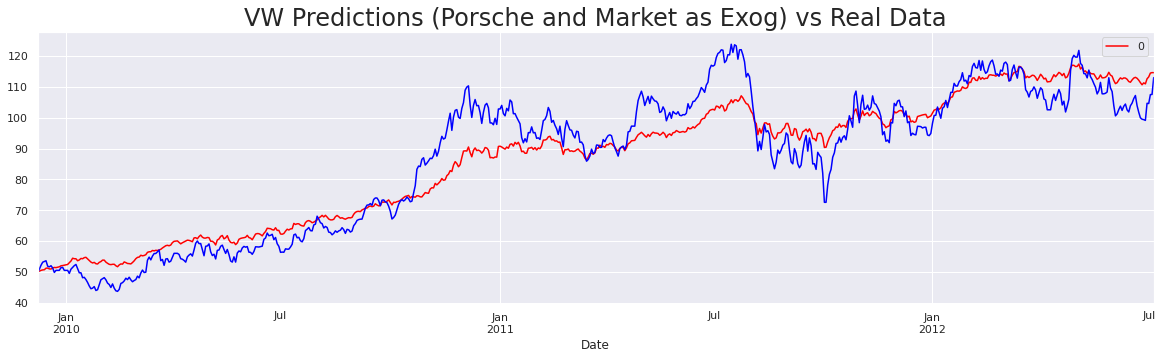

In [187]:
# Attempt to Predict VW price with BMW & Porsche from start date to first announcement 
# Adding Porsche will only adapt to smaller shift better as generally VW and BMW prices are more correlated at the time
model_auto_pred_pr = auto_arima(df['vol'][start_date:ann1_date], exogenous = df[['por', 'bmw']][start_date:ann1_date],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann1_date:ann2_date]), exogenous = df[['por','bmw']][ann1_date:ann2_date]),
                               index = df[ann1_date:ann2_date].index)
df_auto_pred_pr[ann1_date:ann2_date].plot(figsize = (20,5), color = "red")

df['vol'][ann1_date:ann2_date].plot(color = "blue")
plt.title("VW Predictions (Porsche and Market as Exog) vs Real Data", size = 24)
plt.show()

# Seems like the model predicted the high level trend pretty well. 
# Used data before first announcement to predict later time until second announcement.

## Volatility Check

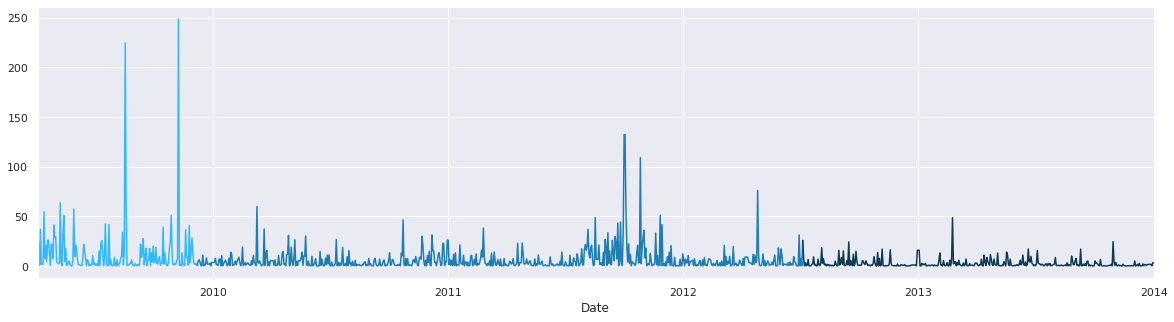

In [190]:
df['ret_sq_vol'][start_date:ann1_date].plot(figsize = (20,5), color = "#33B8FF")
df['ret_sq_vol'][ann1_date:ann2_date].plot(color = "#1E7EB2")
df['ret_sq_vol'][ann2_date:end_date].plot(color = "#0E3A52")
plt.show()

In [191]:
model_garch_pre = arch_model(df['return_vol'][start_date:ann1_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df['return_vol'][ann1_date:ann2_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df['return_vol'][ann2_date:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 475.80958936604276
Iteration:     10,   Func. Count:     65,   Neg. LLF: 475.0292496578668
Iteration:     15,   Func. Count:     95,   Neg. LLF: 474.9905156506354
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 474.99051559834595
            Iterations: 15
            Function evaluations: 95
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1526.9228181801423
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1526.731671462164
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1526.7316714609192
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     38,   Neg. LLF: 724.5623552188874
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 724.5581359874934
            Iterations: 7
         

In [192]:
print(results_garch_pre.summary())
# beta is 0, so ARCH model should be sufficient

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             return_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.991
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Mon, Apr 05 2021   Df Residuals:                      177
Time:                        19:16:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.67

In [193]:
print(results_garch_btn.summary())
# beta is significant = conditional variance is needed
# mu & omega are significant = some constant trend in price return & volatility is observed

# So returns and volatility are not perfectly stable

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             return_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Mon, Apr 05 2021   Df Residuals:                      671
Time:                        19:16:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-0

In [194]:
print(results_garch_post.summary())
# omega & alpha are not significant. This implies auto-correlation in volatility that fits volatility clustering
# beta also dropped, which further suggests the interval to be stable\

# Conclusion: purchase of Porsche has led to the death of rumours & provided VW larger market share.
# volatility dropped after each announcement, making VW stock more appealing

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             return_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Mon, Apr 05 2021   Df Residuals:                      389
Time:                        19:16:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-0